In [32]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import more_itertools
import networkx as nx
import numpy as np
import numpy.linalg as la
from numpy.typing import NDArray
from tqdm.notebook import tqdm
import pandas as pd


import d3networkx as d3nx
from d3networkx.d3graph import D3DiGraph

from dcns.close_edges import get_close_edges
from dcns.graph_utils import node_attr_list_to_ndarray
from dcns.powerlaw import calc_powerlaw_multi

In [33]:
stops = pd.read_csv("./data/gtfs-dart-2023-02-28/stops.txt")

G_time = D3DiGraph(nx.read_gml("data/dart_stops_time.gml"))
G_freq = D3DiGraph(nx.read_gml("data/dart_stops_freq.gml"))
G_freq_over5000 = D3DiGraph(nx.read_gml("data/dart_stops_freq_over5000.gml"))
# Unpack node pos from list to numpy array
node_attr_list_to_ndarray(G_time, "pos")
# G = D3DiGraph(nx.path_graph(5, create_using=nx.DiGraph))

# d3.clear()
# d3.set_graph(G)
# d3.update
# d3.set_interactive(True)

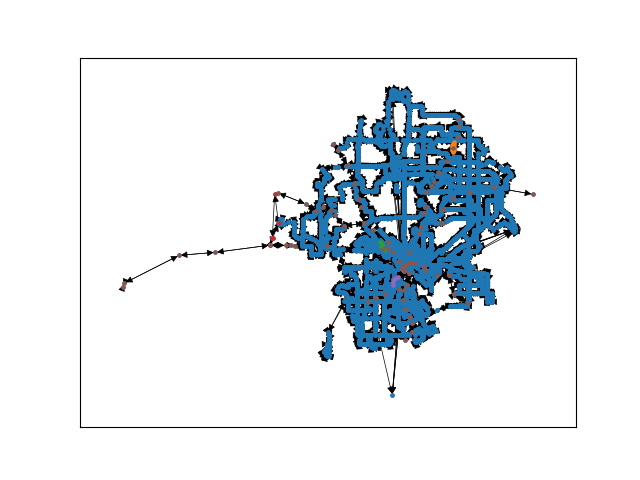

In [21]:
%matplotlib widget
pos = nx.get_node_attributes(G_time, "pos")

comps = list(nx.weakly_connected_components(G_time))

# Plot each weakly-connected component in its own color
nx.draw_networkx(G_time, pos=pos, node_size=5, width=0.5, with_labels=False)
colors = plt.get_cmap('tab10').colors # type: ignore

for component, color in zip(comps, colors):
    nx.draw_networkx(
        G_time.subgraph(component),
        pos=pos,
        node_color=[color],
        node_size=5,
        width=0.5,
        with_labels=False,
    )

In [4]:
# Reload powerlaw (if necessary)
# del calc_powerlaw_multi
import dcns.pathfinding
import importlib
importlib.reload(dcns.pathfinding)

<module 'dcns.pathfinding' from 'c:\\Users\\shaol\\source\\DCNS-S23-Project\\dcns\\pathfinding.py'>

In [5]:
G2 = G_time.__class__(G_time.subgraph(max(nx.strongly_connected_components(G_time), key=len)))
# nx.set_edge_attributes(G2, nx.get_edge_attributes(G2, "num_trips"), "weight") 

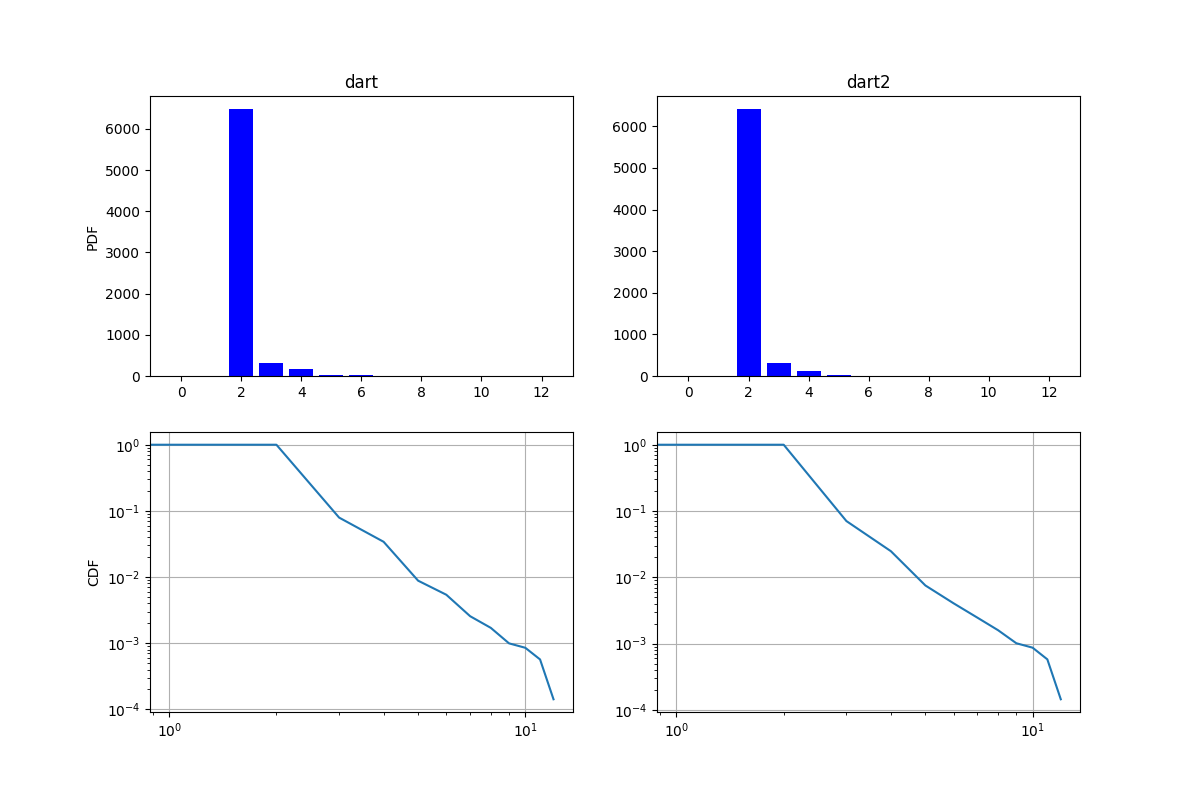

In [6]:
calc_powerlaw_multi({"dart": G_time, "dart2": G2})
plt.show()

In [7]:
from dcns.pathfinding import dijkstra, astar, astar_search, pathfind_steps

len(pathfind_steps(astar_search(G2, "30141", "31212"), "30141", "31212")[1])

2

In [8]:
from dcns.pathfinding import dijkstra, astar, astar_search, pathfind_steps


goals = [
    ("30141", "31212"),
    ("16516", "31212"),
    ("20527", "29291"),
    ("33302", "30496"),
    ("33286", "16971"),
]
# 30141 & 30140

start = goals[0][0]
end = goals[0][1]

len(astar(G2, start, end)[0])

117

MovieWriter imagemagick unavailable; using Pillow instead.


33


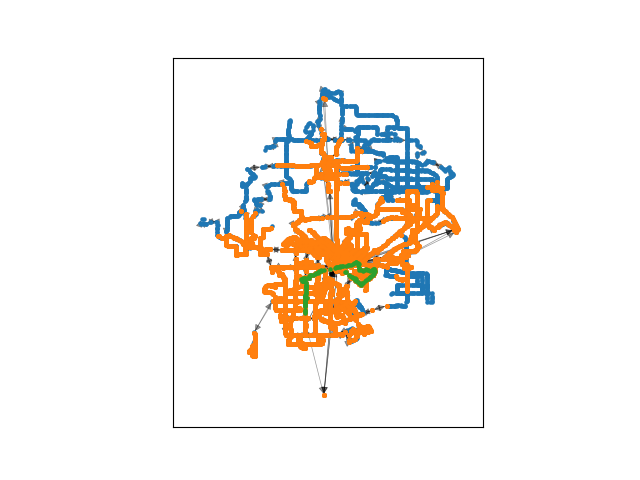

In [9]:
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random

fig, ax = plt.subplots()

pos = nx.get_node_attributes(G_time, "pos")

steps = pathfind_steps(
    astar_search(G2, "30141", "31212"), "30141", "31212", sample_steps=(200, 10)
)
style = {"node_size": 5}
print(len(steps))


def init():
    # Only draw edges over a threshold for faster displaying
    edges = [(u, v) for u, v in G2.edges() if np.linalg.norm(pos[u] - pos[v]) > 0.007]
    nx.draw_networkx_edges(
        G2,
        pos=pos,
        ax=ax,
        edgelist=edges,
        alpha=0.4,
        width=0.5,
        **style,
    )
    ax.set_aspect("equal")

    # Draw nodes
    nx.draw_networkx_nodes(G2, pos=pos, ax=ax, node_color="tab:blue", node_size=5)


def update(frame: int):
    if frame >= len(steps):
        return

    searched_nodes, path_nodes = steps[frame]

    # Draw the updated graph with new node colors
    nx.draw_networkx_nodes(
        G2,
        pos=pos,
        ax=ax,
        nodelist=searched_nodes,
        node_color="tab:orange",
        node_size=5,
    )
    nx.draw_networkx_nodes(
        G2,
        pos=pos,
        ax=ax,
        nodelist=path_nodes,
        node_color="tab:green",
        node_size=5,
    )


# Create an animation object
anim = FuncAnimation(
    fig, update, init_func=init, interval=100, frames=len(steps) + 3, repeat=True
)

# Note: for this to work, you must have ImageMagick installed on your computer AND you
# must set to the path to `convert.exe` (ImageMagick < 7.x) or `magick.exe` for
# (ImageMagick >= 7.x) in the `matplotlibrc` file.
#
# animation.convert_path: C:\Program Files\ImageMagick-7.1.1-Q16-HDRI\magick.exe
#
# See: https://matplotlib.org/stable/tutorials/introductory/customizing.html
anim.save("./anim.gif", writer="imagemagick", fps=10)

In [10]:
anim.save("./anim.gif", writer="imagemagick")

MovieWriter imagemagick unavailable; using Pillow instead.


In [11]:
from IPython.display import HTML

HTML(anim.to_jshtml())

In [12]:
close_edges = get_close_edges(nx.get_node_attributes(G2, "pos"), 0.0005, 50)
# Add 2-way edges for crossing the street
weight=1000
G2.add_weighted_edges_from(ebunch_to_add={(u, v, weight) for u, v in close_edges})
G2.add_weighted_edges_from(ebunch_to_add={(v, u, weight) for u, v in close_edges})

100%|██████████| 2500/2500 [00:07<00:00, 333.07it/s]


In [13]:
%matplotlib widget
nx.draw(G2, pos=pos, node_size=5, width=0.5, with_labels=False)

In [14]:
v = nx.katz_centrality(G2)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('20431', 0.024121808470581017),
 ('33245', 0.017330884066566143),
 ('33221', 0.01712656145339903),
 ('14071', 0.017077081909343667),
 ('33229', 0.016748426512332305)]

In [15]:
v = nx.eigenvector_centrality(G_freq)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('28264', 0.5368265196350608),
 ('22749', 0.4591515527756928),
 ('22748', 0.45889848812278444),
 ('28172', 0.2501210784473024),
 ('29825', 0.24689415583573063)]

In [16]:
nx.diameter(G2)
# Diameter = 356

200

In [17]:
nx.is_tree(G2)

False

In [40]:
# Centrality
# G_freq is a directed graph and is what we will be analyzing in this section
# Functions
stops = pd.read_csv("./data/gtfs-dart-2023-02-28/stops.txt")

def print_top_5(G,v,s=stops, num=5):
    thenodes = list(G.nodes())
    idx_list = [(i,v[i]) for i in range(len(v))]
    idx_list = sorted(idx_list, key = lambda x: x[1], reverse=True)
    for i in range(min(num,len(idx_list))):
        nidx, score = idx_list[i]
        print('  %i. %s (%1.4f)' % (i+1,s[s.stop_id == int(thenodes[nidx])].stop_name,score))
        #print '  %i. %s' % (i+1,G.node_object(idx))

def centrality_vector(G,d):
    thenodes = list(G.nodes())
    v = np.zeros((G.number_of_nodes(),))
    for i,u in enumerate(thenodes):
        v[i] = d[u]
    return v

def node_index(G,n):
    thenodes = list(G.nodes())
    return thenodes.index(n)

# Degree centrality
d = {}
for n in G_freq.nodes():
    d[n] = G_freq.degree(n)
v_degree = centrality_vector(G_freq,d)
print("Degree centrality:")
print_top_5(G_freq,v_degree)
print("\n")

# Eigenvector centrality
d = nx.eigenvector_centrality(G_freq,tol=1e-3,weight='weight')
v_eig = centrality_vector(G_freq,d)
print("Eigenvector centrality:")
print_top_5(G_freq,v_eig)
print("\n")

# Katz centrality
d = nx.katz_centrality(G_freq,0.001,0.01,tol=1e-3,weight='weight')
v_katz = centrality_vector(G_freq,d)
print("Katz centrality:")
print_top_5(G_freq,v_katz)
print("\n")

Degree centrality:
  1. 6557    SOUTHWEST MEDICAL DISTRICT/PARKLAND
Name: stop_name, dtype: object (12.0000)
  2. 3116    ELM @ HARWOOD - W - NS
Name: stop_name, dtype: object (11.0000)
  3. 6518    SOUTH GARLAND TC
Name: stop_name, dtype: object (11.0000)
  4. 6534    ADDISON TRANSIT CENTER
Name: stop_name, dtype: object (11.0000)
  5. 6524    DOWNTOWN IRVING/HERITAGE CROSSING STATION
Name: stop_name, dtype: object (10.0000)


Eigenvector centrality:
  1. 2190    ELM @ LAMAR - W - NS
Name: stop_name, dtype: object (0.4900)
  2. 2021    ELM @ GRIFFIN - W - MB
Name: stop_name, dtype: object (0.4434)
  3. 1937    ELM @ FIELD - W - FS
Name: stop_name, dtype: object (0.3686)
  4. 6575    CBD WEST TC
Name: stop_name, dtype: object (0.2446)
  5. 1674    ELM @ AUSTIN - W - NS
Name: stop_name, dtype: object (0.2408)


Katz centrality:
  1. 1937    ELM @ FIELD - W - FS
Name: stop_name, dtype: object (0.0770)
  2. 2021    ELM @ GRIFFIN - W - MB
Name: stop_name, dtype: object (0.0762)
  3. 2190  

In [51]:
# Clustering

# Local clustering coefficients
d = {}
for n in G_time.nodes():
    d[n] = nx.clustering(G_time,nodes=n,weight=None)
list_degrees = [G_time.degree(n) for n in G_time.nodes()]
list_clustering = [d[n] for n in G_time.nodes()]

Min and max degree: 
1
12


Max clustering: 
0
0.5




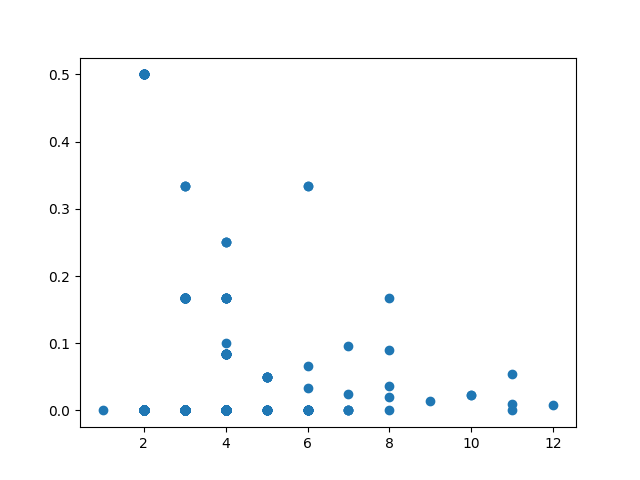

In [54]:
# Clustering
%matplotlib widget
plt.figure()
plt.scatter(np.array(list_degrees),np.array(list_clustering))
plt.show()

In [ ]:
# Cocitation and bibliography
